# Convolutional Neural Network (CNN) - Visualize

This notebook visualizes the most important facial features for predicting trustworthiness using methods like GradCAM and Guided Backpropagation.

---

### Content:

- **1) Load Packages, Data & Model**
- **2) Visualize CNN Activations**
- **3) Visualize Important Facial Features**
    - a) GradCAM
    - b) Guided Backpropagation
    - c) Guided GradCAM

---

# 1) Load Packages, Data & Model

In [2]:
# load basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import matplotlib.image as mpimg

sns.set_style('white')
pd.options.display.max_columns = 100

In [26]:
# load face image data (publication-friendly version)

data_dir = '/Users/kacha/nf-ds/nf_capstone/data/'
Xf_public = np.load(data_dir + 'Xf_public.npy')
Xf_public.shape

(49, 224, 224, 3)

In [3]:
# load trained trust-cnn-model

#!pip install tensorflow==2.0.0
#import tensorflow as tf

from tensorflow.keras.models import load_model

models_dir = '/Users/kacha/nf-ds/nf_capstone/models/final_models/old/'
model_file = models_dir + 'm03d_API_resnet50_30ep_yT_Xf.h5'

model = load_model(model_file)

In [4]:
model.summary()

Model: "m03d_API_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________

---
# 2) Visualize CNN Activations

In [86]:
# instantiate a model from an input tensor and a list of output tensors

# first select layer(s) to show activations for
first,last = 1,5+1
model.layers[first:last]

In [87]:
# Get names of the selected layers, so they can be shown in plot

layer_names = []
for layer in model.layers[first:last]:
    layer_names.append(layer.name) 
layer_names

['conv1/7x7_s2',
 'conv1/7x7_s2/bn',
 'activation_148',
 'max_pooling2d_4',
 'conv2_1_1x1_reduce']

In [88]:
# get input tensor of the model

model_input = model.layers[0].input
model_input

<tf.Tensor 'input_4:0' shape=(None, 224, 224, 3) dtype=float32>

In [89]:
# get list of output tensors for the selected layer(s)

layer_outputs = [layer.output for layer in model.layers[first:last]]
layer_outputs

[<tf.Tensor 'conv1/7x7_s2/Identity:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'conv1/7x7_s2/bn/Identity:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'activation_148/Identity:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4/Identity:0' shape=(None, 55, 55, 64) dtype=float32>,
 <tf.Tensor 'conv2_1_1x1_reduce/Identity:0' shape=(None, 55, 55, 64) dtype=float32>]

In [90]:
# extract outputs of the selected layers by creating a model that returns these outputs given the model input

from tensorflow.keras import models

activation_model = models.Model(inputs=model_input, outputs=layer_outputs) 
activation_model

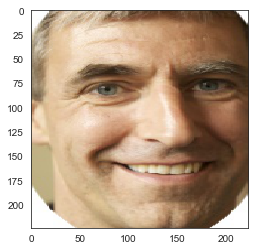

In [91]:
# plot an example input face image

idx = 4
plt.imshow(Xf_public[idx]);

In [97]:
# write function to preprocess image input based on vggface package (as done for training my CNN models)
# see: https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py

def preprocess_input_vggface(x):
    
    x_temp = x*255 # np.copy(x)
    x_temp = x_temp[..., ::-1]
    x_temp[..., 0] -= 91.4953
    x_temp[..., 1] -= 103.8827
    x_temp[..., 2] -= 131.0912

    return x_temp

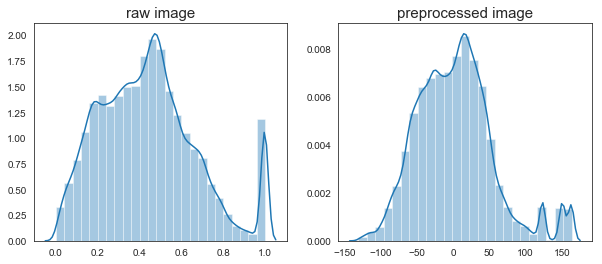

In [108]:
# check pixel value distribution of raw and preprocessed images

plt.figure(figsize=(10,4))
plt.subplot(121)
sns.distplot(Xf_public[:3].ravel(), bins=25)
plt.title('raw image', size=15)
plt.subplot(122)
sns.distplot(preprocess_input_vggface(Xf_public[:3]).ravel(), bins=25)
plt.title('preprocessed image', size=15);

In [98]:
# make input tensor from selected face image (including vggface-like preprocessing of image)

img_tensor = preprocess_input_vggface(Xf_public[idx])
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)

(1, 224, 224, 3)


In [99]:
# returns a list of numpy arrays (one array per layer activation)

activations = activation_model.predict(img_tensor) 

(1, 112, 112, 64)


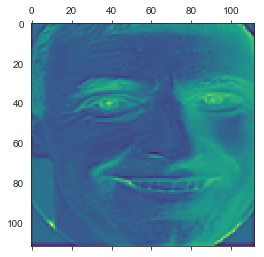

In [100]:
# show activation for one of the feature maps returned by the first selected layer (for demonstration)

first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis');

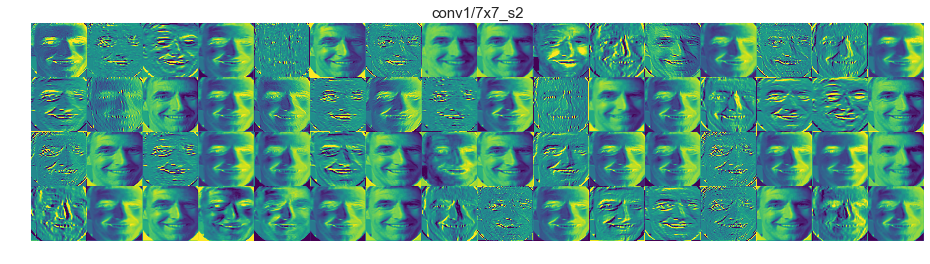

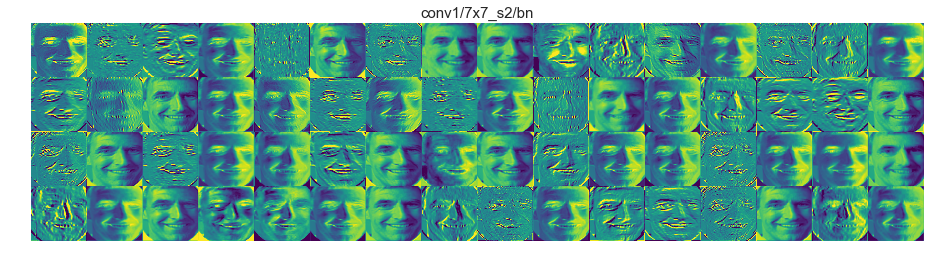

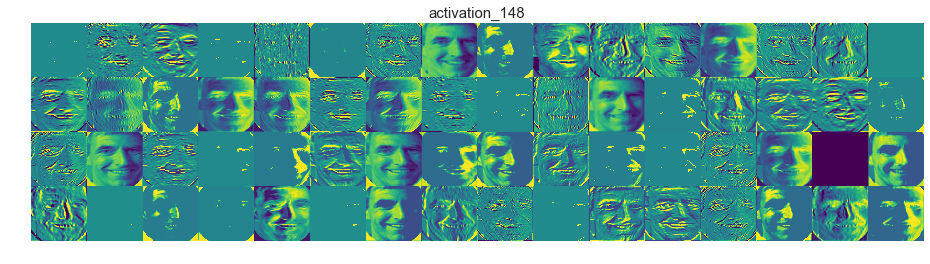

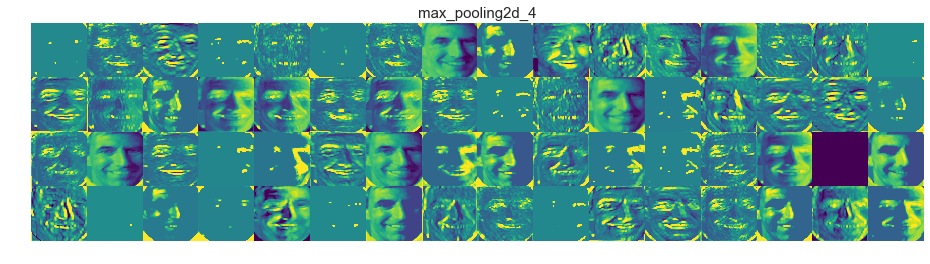

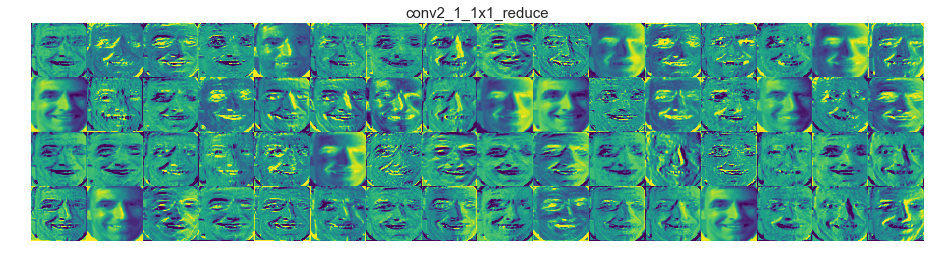

In [101]:
# plot activation maps for all the selected layers
# see: https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-
#      networks-with-keras-260b36d60d0


import warnings
warnings.filterwarnings('ignore')

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    
    n_features = layer_activation.shape[-1]   # number of features in the feature map
    size = layer_activation.shape[1]          # the feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row     # tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):                 # tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col * images_per_row + row]
            channel_image -= channel_image.mean()  # post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,                     # displays the grid
                         row * size : (row + 1) * size] = channel_image
            
    #vmin = display_grid.min().min()
    #vmax = display_grid.max().max()
    scale = 1. / size
    #plt.figure(figsize=(20,50))
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0]))
    plt.title(layer_name, size=15)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')  #, vmin=vmin, vmax=vmax, cmap='bone')

---
# 3) Visualize Important Facial Features
based on: https://github.com/eclique/keras-gradcam/blob/master/gradcam_vgg.ipynb

### a) GradCAM

In [122]:
# load required packages

from keras import backend as K
from tensorflow.python.framework import ops
import cv2

Using TensorFlow backend.


In [110]:
# get list of layer names

all_layer_names = []
for layer in model.layers:
    all_layer_names.append(layer.name)
all_layer_names[:5]

['input_4',
 'conv1/7x7_s2',
 'conv1/7x7_s2/bn',
 'activation_148',
 'max_pooling2d_4']

In [113]:
# get sublist of all convolutional layer names

conv_layer_list = [layer for layer in all_layer_names if layer.startswith('conv')]
conv_layer_list[:5]

['conv1/7x7_s2',
 'conv1/7x7_s2/bn',
 'conv2_1_1x1_reduce',
 'conv2_1_1x1_reduce/bn',
 'conv2_1_3x3']

In [117]:
# get sublist of all basic convolutional layer names (not reduce/increase, batch_normalization, or proj layers)

conv_layer_list_short = [layer for layer in conv_layer_list if len(layer)<=12]
conv_layer_list_short

['conv1/7x7_s2',
 'conv2_1_3x3',
 'conv2_2_3x3',
 'conv2_3_3x3',
 'conv3_1_3x3',
 'conv3_2_3x3',
 'conv3_3_3x3',
 'conv3_4_3x3',
 'conv4_1_3x3',
 'conv4_2_3x3',
 'conv4_3_3x3',
 'conv4_4_3x3',
 'conv4_5_3x3',
 'conv4_6_3x3',
 'conv5_1_3x3',
 'conv5_2_3x3',
 'conv5_3_3x3']

In [119]:
# check model input and output
print(model.output[0,0])
print(model.input)

# check output of a chosen layer, e.g. the very first convolutional layer ('conv1/7x7_s2')
layer_name = conv_layer_list_short[0]
conv_output = model.get_layer(layer_name).output
print(conv_output)

Tensor("strided_slice_1:0", shape=(), dtype=float32)
Tensor("input_4:0", shape=(None, 224, 224, 3), dtype=float32)
Tensor("conv1/7x7_s2/Identity:0", shape=(None, 112, 112, 64), dtype=float32)


In [120]:
# write function to get grad_cam from model and image
# see: https://github.com/eclique/keras-gradcam/blob/master/gradcam_vgg.ipynb

def grad_cam(input_model, image_idx, layer_name):
    """GradCAM method for visualizing input saliency."""
    
    img_tensor = preprocess_input_vggface(Xf_public[image_idx])
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    y = input_model.output[0, 0]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y, conv_output)[0]
    
    # Normalize if necessary
    #grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([img_tensor])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    H, W = Xf_public.shape[1], Xf_public.shape[1]
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [123]:
# Call function with my model and one example image as input tensor (may take 1-2 minutes)

image_idx = 4
layer_name = conv_layer_list_short[0] 
cam = grad_cam(input_model = model, 
               image_idx = image_idx, 
               layer_name = layer_name)

# good: 'conv1/7x7_s2', 'conv2_1_3x3', 'conv4_4_3x3', 'conv3_3_3x3', 'conv3_4_3x3'
# bad: 'conv2_2/3_3x3', 'conv4_1/2/3/5/6_3x3', 'conv5_1/2/3_3x3'

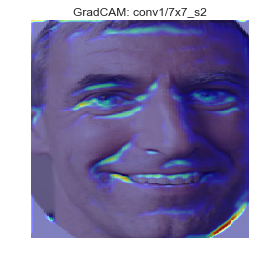

In [124]:
# visualize GradCAM for example image and selected layer

plt.title('GradCAM: ' + layer_name)
plt.axis('off')
plt.imshow(Xf_public[image_idx])
plt.imshow(cam, cmap='jet', alpha=0.5);

### b) Guided Backpropagation

In [128]:
# load required packages

import tensorflow as tf
from tensorflow.python.framework import ops
from keras import backend as K

In [130]:
# write function to build model
# see: https://github.com/eclique/keras-gradcam/blob/master/gradcam_vgg.ipynb

def build_model():
    """Function returning keras model instance.
    
    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    models_path = '/Users/kacha/nf-ds/nf_capstone/models/final_models/old/'
    model_file = models_path + 'm03d_API_resnet50_30ep_yT_Xf.h5'
    model = load_model(model_file)
    
    return model

In [131]:
# write function to build guided model
# see: https://github.com/eclique/keras-gradcam/blob/master/gradcam_vgg.ipynb

def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model

In [132]:
guided_model = build_guided_model()

In [138]:
# write function for guided backpropagation
# see: https://github.com/eclique/keras-gradcam/blob/master/gradcam_vgg.ipynb

def guided_backprop(input_model, image_idx, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    
    img_tensor = preprocess_input_vggface(Xf_public[image_idx])
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([img_tensor, 0])[0]
    return grads_val

In [134]:
# write function to deprocess the image
# see: https://github.com/eclique/keras-gradcam/blob/master/gradcam_vgg.ipynb

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.common.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [147]:
# Call function with my model and one image as input

image_idx = 4
layer_name = conv_layer_list_short[1]
gb = guided_backprop(input_model = guided_model, 
                     image_idx = image_idx, 
                     layer_name = layer_name)

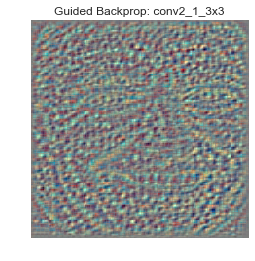

In [148]:
# visualize guided backpropagation for example image and selected layer

plt.title('Guided Backprop: ' + layer_name)
plt.axis('off')
plt.imshow(np.flip(deprocess_image(gb[0]), -1));

### c) Guided GradCAM

In [141]:
# combine GradCAM and guided backpropagation (may take 1-2 minutes to run)

image_idx = 4
layer_name = 'conv2_1_3x3'
gradcam = grad_cam(model, image_idx, layer_name)
gb = guided_backprop(guided_model, image_idx, layer_name)
guided_gradcam = gb * gradcam[..., np.newaxis]

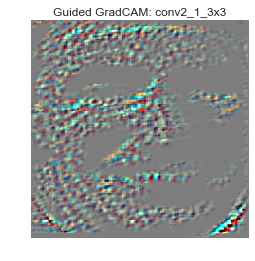

In [143]:
# visualize guided GradCAM for example image and selected layer

plt.title('Guided GradCAM: ' + layer_name)
plt.axis('off')
plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
plt.show()